In [1]:
import pandas as pd
import numpy as np
import json
import yaml
from scipy import stats
import seaborn as sn
import pickle

from os.path import exists
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import rankdata

In [2]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [3]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [17]:
metrics =  [
    #'Model Parameter Randomisation',
    'Monotonicity Nguyen',
    'Monotonicity Arya',
    #'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    #'Avg-Sensitivity',
    #'Random Logit',
    #'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity',
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = {
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
}
                
baselines = [
    'baseline_black',
    # 'baseline_mean', not used anymore as there's some probs with quantus implementation
    #'baseline_random',
    #'baseline_uniform',
    #'baseline_white'
]

transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': lambda x: x,
    'Faithfulness Correlation': lambda x: x, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    "Selectivity": lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: -parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', 'gaussian', 'polycam',
           'cameras', 'extremal_perturbation']

#models = ['resnet50', 'vgg16']
models = ['resnet50']
datasets = ['imagenet']

dico_ranks = {}

In [16]:
# check if recomputed metrics are done
#import os

#metrics2 =  [
#    'Monotonicity Nguyen',
#    'Local Lipschitz Estimate',
#    'Faithfulness Estimate',
#    'Faithfulness Correlation',
#    'Avg-Sensitivity',
#    'Random Logit',
#    'Max-Sensitivity',
#    #'Sparseness', 
#    #'EffectiveComplexity',
#    'Monotonicity Arya',
#    #'Complexity',
#    'Pixel-Flipping',
#    #'Selectivity',
#    'Model Parameter Randomisation'
#]

#filenames = []
#for metr in metrics2:
#    if metr in metrics_with_different_baselines:
#        for baseline in baselines:
#            for meth in methods:
#                filenames.append(f'{meth}_{model}_{dataset}_{metr}_{baseline}.csv')
#    else:
#        for meth in methods:
#            filenames.append(f'{meth}_{model}_{dataset}_{metr}.csv')

#existing_files = set(os.listdir('csv_new'))
#lacking_files = [f for f in filenames if f not in existing_files]
#sorted(lacking_files)

['polycam_resnet50_imagenet_Avg-Sensitivity.csv',
 'polycam_resnet50_imagenet_Local Lipschitz Estimate.csv',
 'polycam_resnet50_imagenet_Max-Sensitivity.csv',
 'polycam_resnet50_imagenet_Model Parameter Randomisation.csv',
 'rise_resnet50_imagenet_Model Parameter Randomisation.csv']

In [19]:
CSV_DIR = 'csv_merged_rebuttal'

for dataset in datasets:
    print(f'DATASET {dataset.upper()}')
    dico_ranks[dataset] = {}
    for model in models:
        print(f'MODEL {model.upper()}')
        dico_ranks[dataset][model] = {}
        for metr in metrics:
            if metr in metrics_with_different_baselines:
                for baseline in baselines:
                    data = pd.DataFrame()
                    metr_with_baseline = f'{metr} with {baseline}'
                    print(f"-- Metric: {metr_with_baseline}")
                    for meth in methods:
                        if meth == 'cameras' or meth == 'extremal_perturbation' or model == 'vgg16':
                            csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
                        else:
                            csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                        df = pd.read_csv(csv_name, header = None)
                        data[meth] = transform[metr](df).values.flatten()
                    ranks = np.array([rankdata(-p) for p in data.values])
                    average_ranks = np.mean(ranks, axis=0)
                    dico_ranks[dataset][model][metr_with_baseline] = average_ranks
                    #else:
                        #print(all_files_exists, 'some files are missing, skip')
        #    elif metr == 'Model Parameter Randomisation':
        #        for baseline in ['bottom_up','top_down']:
        #            data = pd.DataFrame()
        #            metr_with_baseline = f'{metr} with {baseline}'
        #            print(f"-- Metric: {metr_with_baseline}")
        #            for meth in methods:
        #                csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
        #                df = pd.read_csv(csv_name, header = None)
        #                data[meth] = transform[metr](df).values.flatten()    
        #            ranks = np.array([rankdata(-p) for p in data.values])
        #            average_ranks = np.mean(ranks, axis=0)
        #            dico_ranks[metr_with_baseline] = average_ranks
            else:
                data = pd.DataFrame()
                print(f"-- Metric: {metr}")
                for meth in methods:
                    csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
                    df = pd.read_csv(csv_name, header = None)
                    data[meth] = transform[metr](df).values.flatten()    
                ranks = np.array([rankdata(-p) for p in data.values])
                average_ranks = np.mean(ranks, axis=0)
                dico_ranks[dataset][model][metr] = average_ranks
        print()
    print()
    print()

with open('rebuttal_rankings_by_rank_aggreg.pickle', 'wb') as file:
    pickle.dump(dico_ranks, file)

DATASET IMAGENET
MODEL RESNET50
-- Metric: Monotonicity Nguyen with baseline_black
-- Metric: Monotonicity Arya with baseline_black
-- Metric: Faithfulness Estimate with baseline_black
-- Metric: Faithfulness Correlation with baseline_black
-- Metric: Sparseness
-- Metric: EffectiveComplexity
-- Metric: Complexity
-- Metric: Pixel-Flipping with baseline_black
-- Metric: Selectivity with baseline_black





In [8]:
with open('rebuttal_rankings_by_rank_aggreg.pickle', 'rb') as file:
    dico_ranks = pickle.load(file)

In [20]:
def compute_kendall_w(dico_ranks, metrics):
    rankings = [rankdata(dico_ranks[metric]) for metric in metrics]
        
    data = []
    for i in range(len(rankings[0])):
        data.append([rankings[j][i] for j in range(len(rankings))])   
    
    # source of the implementation : https://github.com/ugolbck/kendall-w/blob/master/kendall_w/kendall_w.py
    m = len(data[0])
    n = len(data)
    sums = [sum(x) for x in data]
    Rbar = sum(sums) / n
    S = sum([(sums[x] - Rbar) ** 2 for x in range(n)])
    W = (12 * S) / (m ** 2 * (n ** 3 - n))

    return W

In [21]:
def compute_kendall_tau(dico_ranks, metrics):
    tau_values = []
    p_values = []

    for metric_a in metrics:
        current_tau_values = []
        current_p_values = []
        for metric_b in metrics:
            tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
            current_tau_values.append(tau)
            current_p_values.append(p_value)
        tau_values.append(current_tau_values)
        p_values.append(current_p_values)
        
    return tau_values, p_values

In [22]:
def plot_corr_matrix_figure(dico_ranks, metrics, y_labels, x_labels, filename, fig_size, rotate_x=True, half_rotate_x=False, rotate_y=True, subgroups=None):
    tau_values, p_values = compute_kendall_tau(dico_ranks, metrics)
    
    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')

    sn.set(rc={'figure.figsize': fig_size})

    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = reject[current_post]
            mask[j][i] = reject[current_post]
            current_post += 1

    sn.heatmap(tau_values,
               annot=True,
               vmin=-1,
               vmax=1,
               cbar=False,
               xticklabels=x_labels,
               yticklabels=y_labels,
               mask=mask,
               cmap='viridis')

    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = not reject[current_post]
            mask[j][i] = not reject[current_post]
            current_post += 1
        mask[i][i] = False

    ax = sn.heatmap(tau_values,
                    annot=True,
                    annot_kws={"style": "italic", "weight": "bold"},
                    vmin=-1,
                    vmax=1,
                    cbar=False,
                    xticklabels=x_labels,
                    yticklabels=y_labels,
                    mask=mask,
                    cmap='viridis')

    if half_rotate_x:
        plt.xticks(rotation=20, ha="right")
    elif rotate_x:
        plt.xticks(rotation=0)
    if rotate_y:
        plt.yticks(rotation=0)
    
    start_i = 0
    if subgroups:
        for subgroup_size in subgroups:
            ax.add_patch(Rectangle((start_i, start_i), subgroup_size, subgroup_size, fill=False, edgecolor='crimson', lw=4, clip_on=False))
            start_i += subgroup_size
    
    plt.savefig(f'./results/{filename}.eps', bbox_inches='tight', format='eps')
    plt.show()
    plt.close()
    
    print('RESULTS')
    print(f"Kendall's W: {compute_kendall_w(dico_ranks, metrics)}")
    print("Kendall's Tau:")
    for i, metric_a in enumerate(metrics):
        for j, metric_b in enumerate(metrics):
            if i < j:
                print(f'{metric_a} / {metric_b} : {tau_values[i][j]} ({p_values[i][j]})')

In [23]:
def plot_same_baseline_diff_metrics_figure(dico_ranks, baseline):   
    selected_metrics = sorted([metric for metric in dico_ranks.keys() if baseline in metric])
    labels = ['Faithfulness Correlation (FC)','Faithfulness Estimate (FE)','Monotonicity Arya (MA)','Monotonicity Nguyen (MN)','Pixel-Flipping (PF)','Selectivity (Se)']
    short_labels = ['FC','FE', 'MA','MN','PF','Se']
    filename = f'rebuttal_final_corr_matrix_rank_aggreg_holm_corr_faithfulness_{baseline}'
    plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(5,3))

In [25]:
def plot_same_metric_diff_baselines_figure(dico_ranks, metric):   
    selected_metrics = sorted([metric_n for metric_n in dico_ranks.keys() if metric in metric_n])
    labels = ['Black (B)', 'Random (R)', 'Uniform (U)', 'White (W)']
    short_labels = ['B','R', 'U','W']
    filename = f'rebuttal_final_corr_matrix_rank_aggreg_holm_corr_faithfulness_{metric}'
    plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(3,2))

# Figures and results for rebuttal

## ResNet50

In [26]:
df_ranks = pd.DataFrame(dico_ranks['imagenet']['resnet50'], index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

In [27]:
df_ranks

,Monotonicity Nguyen with baseline_black,Monotonicity Arya with baseline_black,Faithfulness Estimate with baseline_black,Faithfulness Correlation with baseline_black,Sparseness,EffectiveComplexity,Complexity,Pixel-Flipping with baseline_black,Selectivity with baseline_black
integratedgrad,7.5460,6.17250,10.4700,9.3410,2.3095,3.99400,2.2935,5.4155,4.6635
smoothgrad,5.6485,7.44075,6.4010,6.6150,8.2730,9.86300,8.4135,6.3535,6.0925
guidedbackprop,6.9515,8.10525,7.0125,8.1225,1.1300,2.68200,1.1170,3.7825,5.8835
rise,7.2230,7.39700,6.7340,6.1695,12.3460,9.70500,12.2900,7.1280,6.4615
gradcam,5.2330,6.99525,4.9725,5.5690,5.4630,4.35275,5.4115,8.0820,8.8695
scorecam,5.3640,7.15650,5.7235,6.1595,7.0925,7.01575,7.0150,8.2745,8.7405
layercam,5.3610,7.52800,5.4315,6.3470,10.0405,9.86300,9.9550,8.1720,8.7000
random,10.0860,6.21450,8.7915,8.5845,7.6380,8.29725,7.4940,4.9105,4.3840
sobel,9.4515,6.21975,9.7845,8.8375,3.5000,7.09475,3.5135,8.6790,6.6570
gaussian,7.4520,4.41925,6.8290,7.4505,12.2490,9.86300,12.3080,8.4675,8.4440


### Faithfulness (with black baseline)

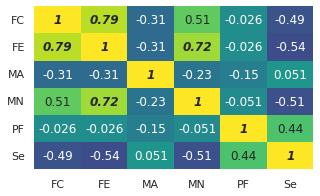

RESULTS
Kendall's W: 0.13522588522588522
Kendall's Tau:
Faithfulness Correlation with baseline_black / Faithfulness Estimate with baseline_black : 0.7948717948717947 (3.1929233318122206e-05)
Faithfulness Correlation with baseline_black / Monotonicity Arya with baseline_black : -0.30769230769230765 (0.16348723839175228)
Faithfulness Correlation with baseline_black / Monotonicity Nguyen with baseline_black : 0.5128205128205127 (0.014950091061202172)
Faithfulness Correlation with baseline_black / Pixel-Flipping with baseline_black : -0.025641025641025637 (0.9523619079608663)
Faithfulness Correlation with baseline_black / Selectivity with baseline_black : -0.4871794871794871 (0.021581605765633543)
Faithfulness Estimate with baseline_black / Monotonicity Arya with baseline_black : -0.30769230769230765 (0.16348723839175228)
Faithfulness Estimate with baseline_black / Monotonicity Nguyen with baseline_black : 0.7179487179487178 (0.00028397849578405134)
Faithfulness Estimate with baseline_blac

In [28]:
plot_same_baseline_diff_metrics_figure(dico_ranks['imagenet']['resnet50'], 'baseline_black')

## Complexity

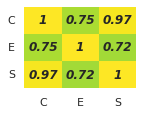

RESULTS
Kendall's W: 0.9328449328449329
Kendall's Tau:
Complexity / EffectiveComplexity : 0.7472647177570733 (0.0005147279617543294)
Complexity / Sparseness : 0.9743589743589742 (4.17535139757362e-09)
EffectiveComplexity / Sparseness : 0.7205766921228921 (0.000811219951696784)


In [29]:
selected_metrics = ['Complexity','EffectiveComplexity','Sparseness']
labels = ['Complexity (C)', 'Effective Complexity (E)', 'Sparseness (S)']
short_labels = ['C','E', 'S']
filename = 'rebuttal_final_corr_matrix_rank_aggreg_holm_corr_complexity'
plot_corr_matrix_figure(dico_ranks['imagenet']['resnet50'], selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

## All metrics

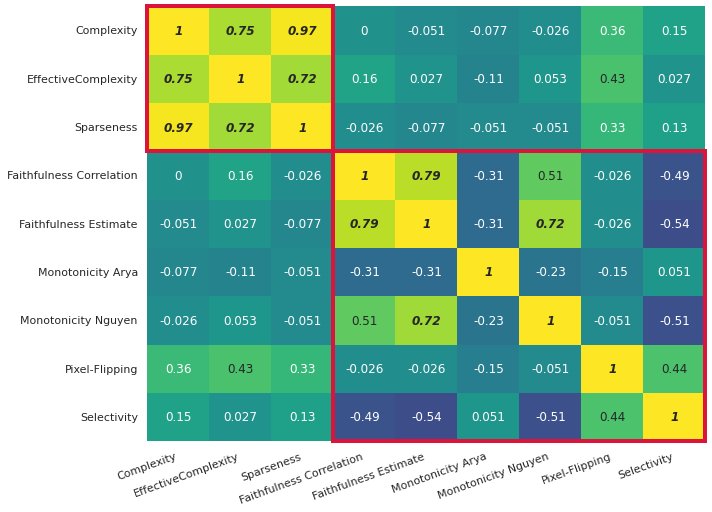

RESULTS
Kendall's W: 0.19006919006919007
Kendall's Tau:
Complexity / EffectiveComplexity : 0.7472647177570733 (0.0005147279617543294)
Complexity / Sparseness : 0.9743589743589742 (4.17535139757362e-09)
Complexity / Faithfulness Correlation with baseline_black : 0.0 (1.0476380920391337)
Complexity / Faithfulness Estimate with baseline_black : -0.05128205128205127 (0.8577337519090992)
Complexity / Monotonicity Arya with baseline_black : -0.07692307692307691 (0.7650248459102625)
Complexity / Monotonicity Nguyen with baseline_black : -0.025641025641025637 (0.9523619079608663)
Complexity / Pixel-Flipping with baseline_black : 0.3589743589743589 (0.0999802599021349)
Complexity / Selectivity with baseline_black : 0.15384615384615383 (0.5097745711721406)
EffectiveComplexity / Sparseness : 0.7205766921228921 (0.000811219951696784)
EffectiveComplexity / Faithfulness Correlation with baseline_black : 0.16012815380508713 (0.45675040242316933)
EffectiveComplexity / Faithfulness Estimate with baseli

In [31]:
selected_metrics =  [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    # 'Model Parameter Randomisation',
    # 'Random Logit',   
    # 'Avg-Sensitivity',
    # 'Local Lipschitz Estimate',
    # 'Max-Sensitivity',
    'Faithfulness Correlation with baseline_black',
    'Faithfulness Estimate with baseline_black',
    'Monotonicity Arya with baseline_black',
    'Monotonicity Nguyen with baseline_black',
    'Pixel-Flipping with baseline_black',
    'Selectivity with baseline_black'    
]

labels = [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    # 'Model Parameter Randomisation',
    # 'Random Logit',   
    # 'Avg-Sensitivity',
    # 'Local Lipschitz Estimate',
    # 'Max-Sensitivity',
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity'    
]

#for metric in metrics:
#    if metric in metrics_with_different_baselines:
#        selected_metrics.append(f'{metric} with baseline_black')
#    elif metr == 'Model Parameter Randomisation':
#        metr_with_baseline = f'{metr} with bottom_up'
#        final_dico_ranks[metr] = dico_ranks[metr_with_baseline]
#    else:
#        selected_metrics.append(metric)
#    labels.append(metric)

# selected_metrics.sort()
# labels.sort()
filename = 'rebuttal_final_corr_matrix_rank_aggreg_holm_corr_all_metrics_default_baselines_with_subgroups'
plot_corr_matrix_figure(dico_ranks['imagenet']['resnet50'], selected_metrics, labels, labels, filename, fig_size=(10,8), half_rotate_x=True, subgroups=(3,6))